In [6]:
import numpy as np
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
from cmath import sqrt


In [14]:
def plot_single_tuning_curve(cell_dictionary,cell_ID):

    fig = plt.figure(1)
    ax = fig.gca()

    # frequency_labels = [5.7,23,45] #,52]
    # intensity_labels = [0,70,80,90] #[50,70,90]

    # frequency_labels = [2,4.5,10,23,52]
    # # intensity_labels = [30,50,70]
    # intensity_labels = [0,50,70,90]

    frequency_labels = [4,8,12,23,45]
    # intensity_labels = [30,50,70]
    intensity_labels = [0,40,60,80]

    # get cell ID at this index so we can pull its tuning curve
    # cell_IDs = list(cell_dictionary.keys())
    # cell_of_interest_ID = cell_IDs[cell_IDX]

    cell_tuning = cell_dictionary[cell_ID]['tuning_curve_peak']

    im = plt.imshow(np.transpose(cell_tuning),cmap='jet',origin='lower')
    plt.colorbar(im)
    # plt.xticks([0,1,2])
    # ax.set_xticklabels(frequency_labels)
    # plt.yticks([0,1,2,3])
    # ax.set_yticklabels(intensity_labels)
    # plt.xticks([0,2,4,6,8])
    # ax.set_xticklabels(frequency_labels)
    # plt.yticks([0,2,4,6])
    # ax.set_yticklabels(intensity_labels)
    plt.xticks([0,1,2,3,4])
    ax.set_xticklabels(frequency_labels)
    plt.yticks([0,1,2,3])
    ax.set_yticklabels(intensity_labels)
    plt.show()

In [57]:
def get_cell_tuning_by_peak(cell_traces,plot_TF):

    if plot_TF:
        fig,axs = plt.subplots(4,5)
        # axs = axs.ravel()

    EPOCH_START_IN_MS = -500
    FRAMERATE = 10

    # cell_traces is a dictionary of frequencies 
    # under each frequency is a dictionary of intensities
    # under each intensity are the traces for each repetitiong of that frequency/intensity combination

    # allocate some space to return
    # we want a matrix that is nFrequencies x nIntensities 
    tuning_curves = np.empty((len(cell_traces),len(cell_traces[next(iter(cell_traces))].keys())))

    n_baseline_frames = round(EPOCH_START_IN_MS/1000 * FRAMERATE)*-1

    plot_coln_counter = 0
    frequency_counter = 0 # to keep track of where we're indexing the empty array
    for freq in cell_traces:
        intensity_counter = 0

        # find the number of intensities we presented at
        n_intensities = len(cell_traces[freq].keys())

        # make a temporary vector to append to the tuning curve at the end of this loop
        # we will fill one n_intensities length column of the 2D matrix we are returning
        activation_per_intensity = np.empty((n_intensities,1))

        # iterate through each intensity the frequency was presented at
        plot_row_counter = 0
        for intensity in cell_traces[freq]:
            # collect all the trials of this one frequency presented at this one intensity
            # it will be an nTrials x nFrames matrix
            all_trials_of_this_intensity = []
            n_baseline_frames = round(EPOCH_START_IN_MS/1000 * FRAMERATE)*-1
            # iterate through each trial of this frequency/intensity combination
            counter=0
            for trial in cell_traces[freq][intensity]:
                
                # if plot_TF:
                #     plt.plot(cell_traces[freq][intensity][trial][n_baseline_frames:])

                counter+=1
                trace = cell_traces[freq][intensity][trial]
                # print(trace)
                # input()
                # baseline = trace[0:n_baseline_frames]
                # baseline_mean = np.average(baseline)
                # baseline_std = np.std(baseline)

                # zscorer = lambda x: (x-baseline_mean)/baseline_std

                # response = trace[n_baseline_frames:]
                # zscore_response = np.array([zscorer(xi) for xi in response])
                all_trials_of_this_intensity.append(trace)

            # plt.show()

            # convert the matrix of trials into a np array
            all_trials_as_np = np.array(all_trials_of_this_intensity)

            # average across all the trials to get a 1 x nFrames vector
            average_trial_of_this_intensity = np.average(all_trials_as_np, axis=0)

            # now we grab the peak of the trace occuring AFTER the onset
            
            # baseline = average_trial_of_this_intensity[0:n_baseline_frames]
            # baseline_mean = np.average(baseline)
            # baseline_std = np.std(baseline)

            # zscorer = lambda x: (x-baseline_mean)/baseline_std

            # response = average_trial_of_this_intensity[n_baseline_frames:]
            # zscore_response = np.array([zscorer(xi) for xi in response])
            response = average_trial_of_this_intensity[n_baseline_frames:]

            if plot_TF:
                error = []
                for timepoint in range(len(all_trials_as_np[0])):
                    if timepoint<n_baseline_frames:
                        continue

                    timepoint_std = np.std(all_trials_as_np[:,timepoint])
                    timepoint_se = timepoint_std/sqrt(len(all_trials_as_np[:,timepoint]))
                    error.append(timepoint_se)

            if plot_TF:
                # print(len(error))
                # print(len(response))
                axs[3-plot_row_counter,plot_coln_counter].plot(np.transpose(all_trials_as_np))
                axs[3-plot_row_counter,plot_coln_counter].axvline(x=4,color='k')
                # axs[plot_row_counter,plot_coln_counter].plot(response)
                # axs[plot_row_counter,plot_coln_counter].fill_between(range(len(response)),response-error,response+error,alpha=0.5)
                axs[3-plot_row_counter,plot_coln_counter].xaxis.set_visible(False)
                axs[3-plot_row_counter,plot_coln_counter].yaxis.set_visible(False)
                axs[3-plot_row_counter,plot_coln_counter].set_ylim(bottom=0,top=500)
                axs[3-plot_row_counter,plot_coln_counter].autoscale(enable=True, axis='x', tight=True)
                # axs[3-plot_row_counter,plot_coln_counter].title.set_text(intensity)
                # axs[plot_row_counter,plot_coln_counter].title.set_text(intensity)
                # axs[5-plot_row_counter,plot_coln_counter].text(10,300,str(intensity))

            # zscore_response = zscore(response)
            peak_response = np.amax(response)
            # peak_response = np.amax(response)
            # peak_response = np.trapz(response)
            tuning_curves[frequency_counter,intensity_counter] = peak_response

            intensity_counter += 1
            # print(freq)
            # print(intensity)
            plot_row_counter += 1

        plot_coln_counter += 1
        frequency_counter += 1
    
    if plot_TF:
        fig.subplots_adjust(wspace=0,hspace=0)
        plt.show()
    return tuning_curves

In [59]:
with open('D:/Lab/2P/Vid_190_PCA/cells.pkl', 'rb') as f:
        cell_dictionary = pickle.load(f)


In [49]:
print(cell_dictionary.keys())

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 108, 109, 110, 112, 113, 115, 116, 118, 121, 122, 123, 124, 125, 126, 127, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 144, 145, 147, 148, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 162, 163, 164, 165, 166, 167, 169, 171, 172, 174, 177, 178, 179, 180, 181, 182, 183, 187, 188, 189, 190, 191, 192, 193, 194, 196, 199, 202, 204, 208, 213, 214, 224, 227, 229, 230, 231, 234, 239, 241, 242, 243, 244, 245, 247, 248, 250, 251, 253, 256, 267, 268, 270, 271, 279, 282, 288, 294, 297, 298, 305, 306, 307, 316, 327, 338, 343, 350, 351, 364, 365, 376, 

False


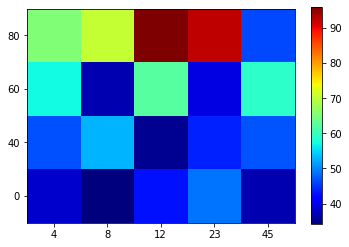

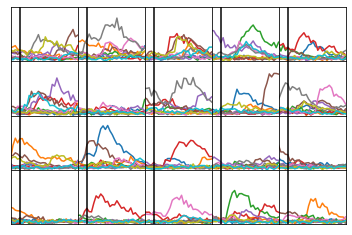

array([[ 43.92943268,  69.51179352,  96.65878067,  81.4886795 ],
       [ 56.32811661,  97.57836113,  44.14102478, 102.94601021],
       [ 57.37185211,  54.75302277,  75.24149551, 107.89963455],
       [ 74.86271286,  51.77459221,  71.42466164, 108.49182129],
       [ 56.91365089,  47.08213425,  82.21552773,  64.31814003]])

In [68]:
cell_ID = 38
print(cell_dictionary[cell_ID]['active'])
plot_single_tuning_curve(cell_dictionary,cell_ID)
get_cell_tuning_by_peak(cell_dictionary[cell_ID]['traces'],True)
